# Employee Attrition Prediction: Neural Network vs XGBoost Analysis
## Introduction to Data Science with Python - Summer School 2025
### Wrocław University of Science and Technology

In [142]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing, metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.utils import to_categorical
from keras import regularizers
from keras.optimizers import Adam
from xgboost import XGBClassifier, plot_importance, plot_tree
import warnings
warnings.filterwarnings('ignore')

In [143]:
# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("Set1")

In [144]:
# Load and explore the dataset
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

Dataset Shape: (1470, 35)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-nu

In [145]:
# Display basic statistics about attrition
print("Attrition Distribution:")
print(df['Attrition'].value_counts())
print(f"\nAttrition Rate: {df['Attrition'].value_counts()['Yes'] / len(df) * 100:.2f}%")

Attrition Distribution:
Attrition
No     1233
Yes     237
Name: count, dtype: int64

Attrition Rate: 16.12%


## **Data Preprocessing**
### *Categorical and numerical features separation*

In [146]:
# Separate categorical and numerical columns
cat_cols = []
num_cols = []
for col in df.columns:
    if col != 'Attrition':  # Target variable
        if df[col].dtype == 'object':
            cat_cols.append(col)
        else:
            num_cols.append(col)

print("Categorical Features:", len(cat_cols))
print("Numerical Features:", len(num_cols))

Categorical Features: 8
Numerical Features: 26


## **Exploratory Data Analysis**

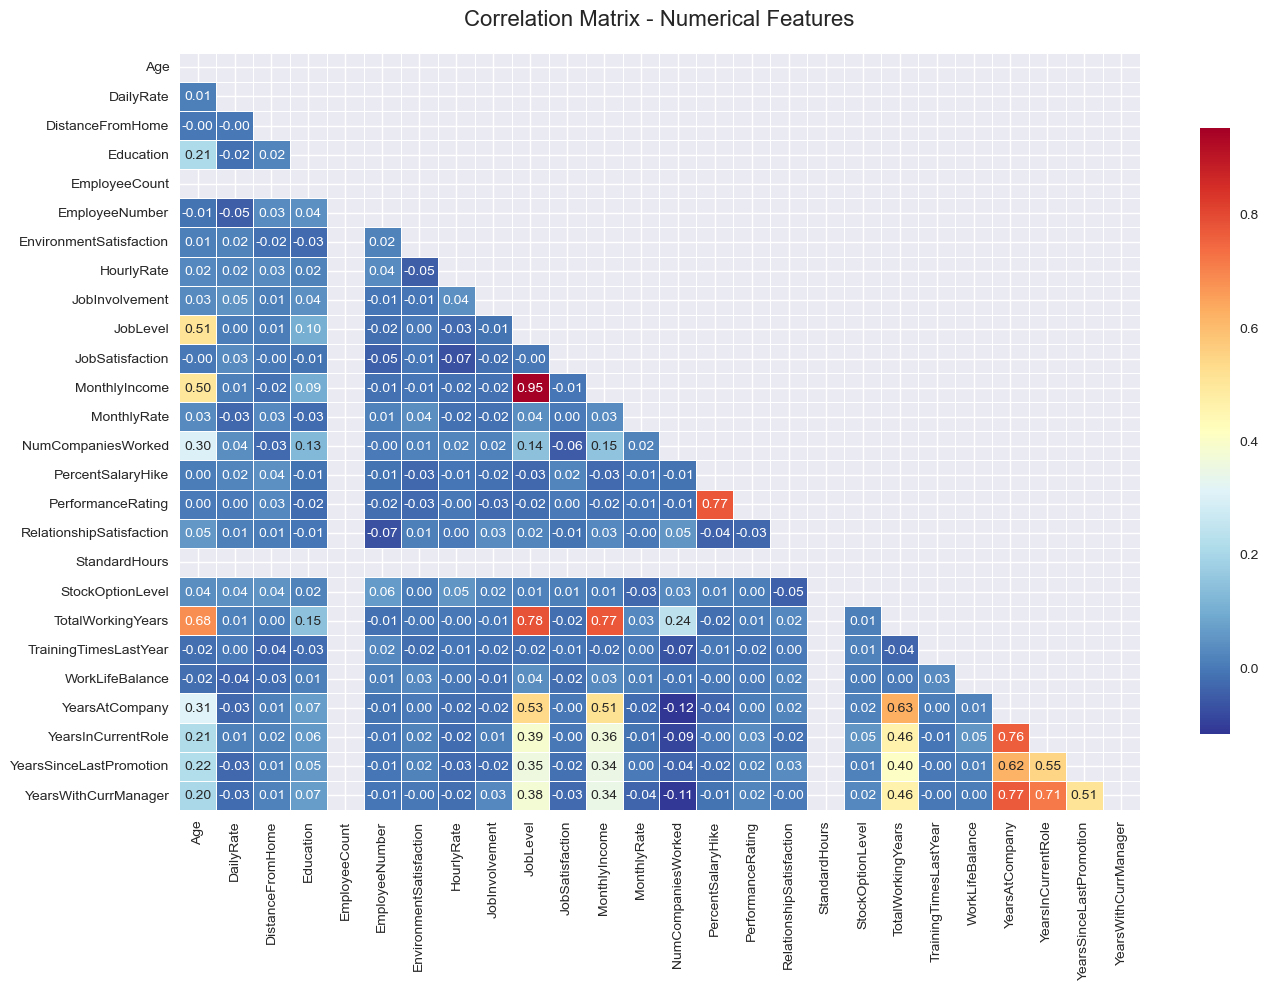

In [147]:
# Correlation matrix for numerical features
plt.figure(figsize=(14, 10))
corr_matrix = df[num_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="RdYlBu_r", fmt=".2f", 
           linewidths=0.5, cbar_kws={"shrink": .8})
plt.title("Correlation Matrix - Numerical Features", fontsize=16, pad=20)
plt.tight_layout()
plt.show()

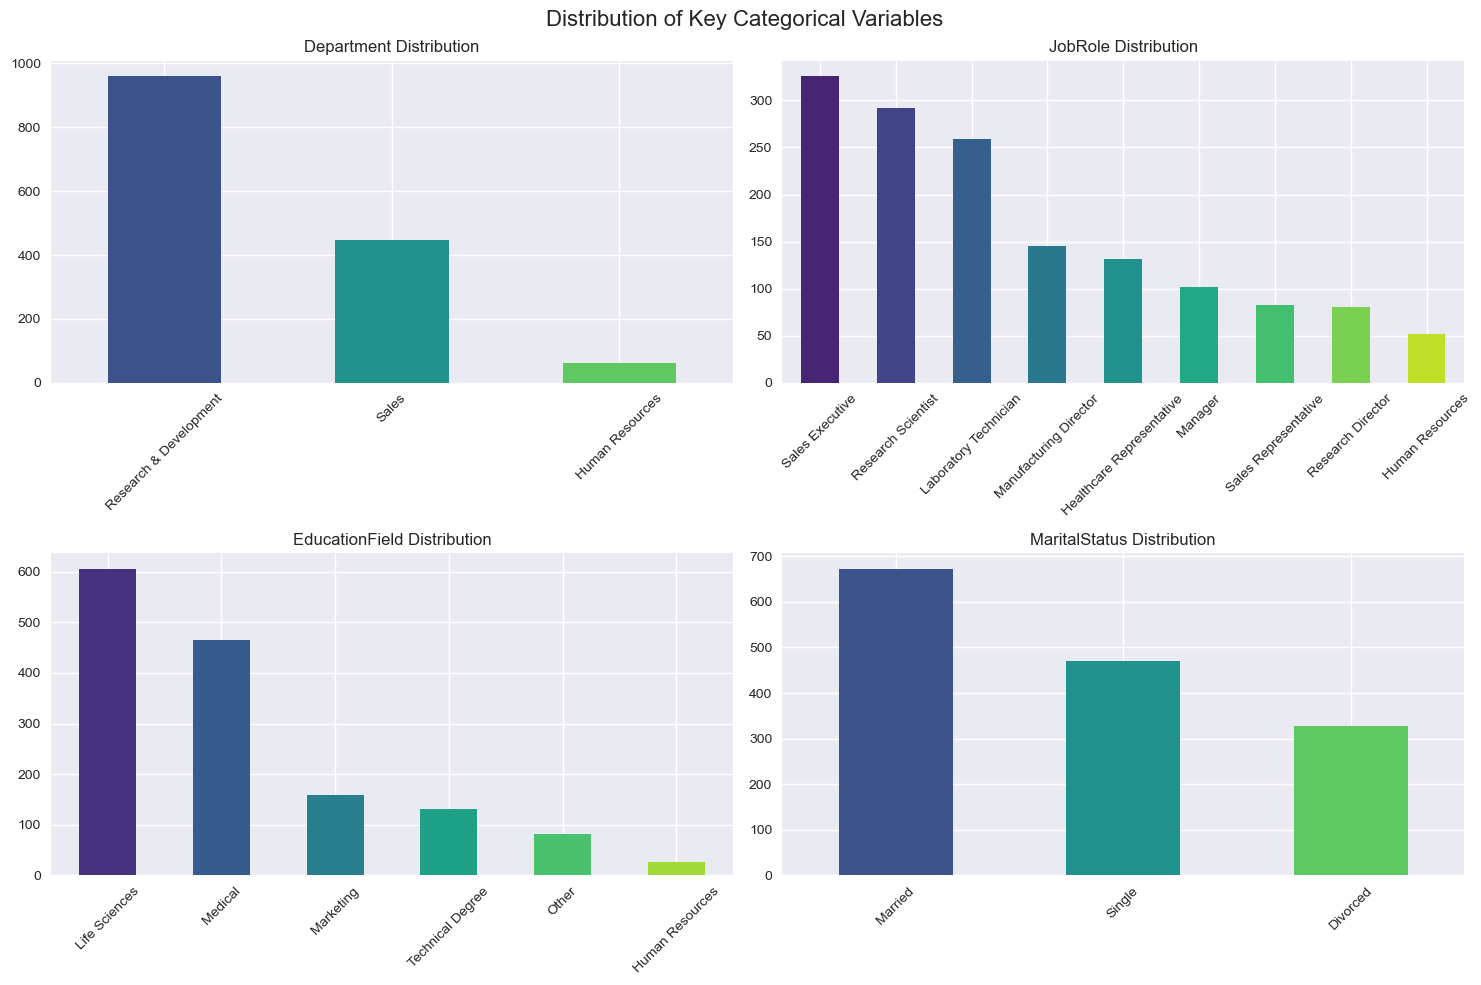

In [148]:
# Distribution of key categorical variables
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Key Categorical Variables', fontsize=16)

key_cats = ['Department', 'JobRole', 'EducationField', 'MaritalStatus']
for i, cat in enumerate(key_cats):
    ax = axes[i//2, i%2]
    df[cat].value_counts().plot(kind='bar', ax=ax, color=sns.color_palette("viridis", len(df[cat].unique())))
    ax.set_title(f'{cat} Distribution')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

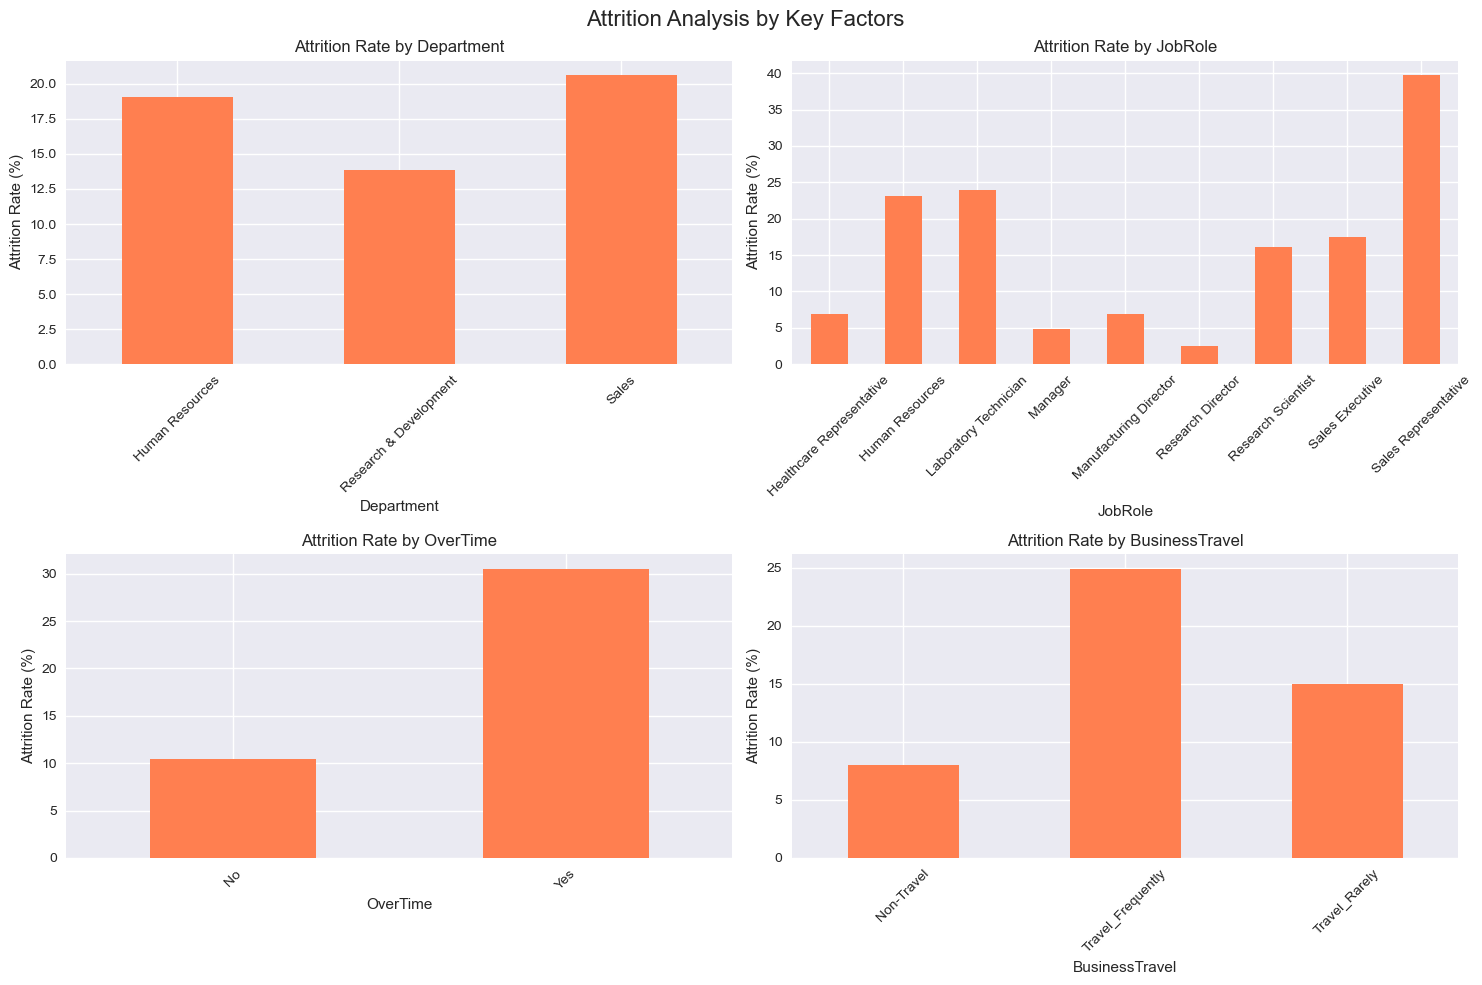

In [149]:
# Attrition by key factors
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Attrition Analysis by Key Factors', fontsize=16)

factors = ['Department', 'JobRole', 'OverTime', 'BusinessTravel']
for i, factor in enumerate(factors):
    ax = axes[i//2, i%2]
    attrition_by_factor = pd.crosstab(df[factor], df['Attrition'], normalize='index') * 100
    attrition_by_factor['Yes'].plot(kind='bar', ax=ax, color='coral')
    ax.set_title(f'Attrition Rate by {factor}')
    ax.set_ylabel('Attrition Rate (%)')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


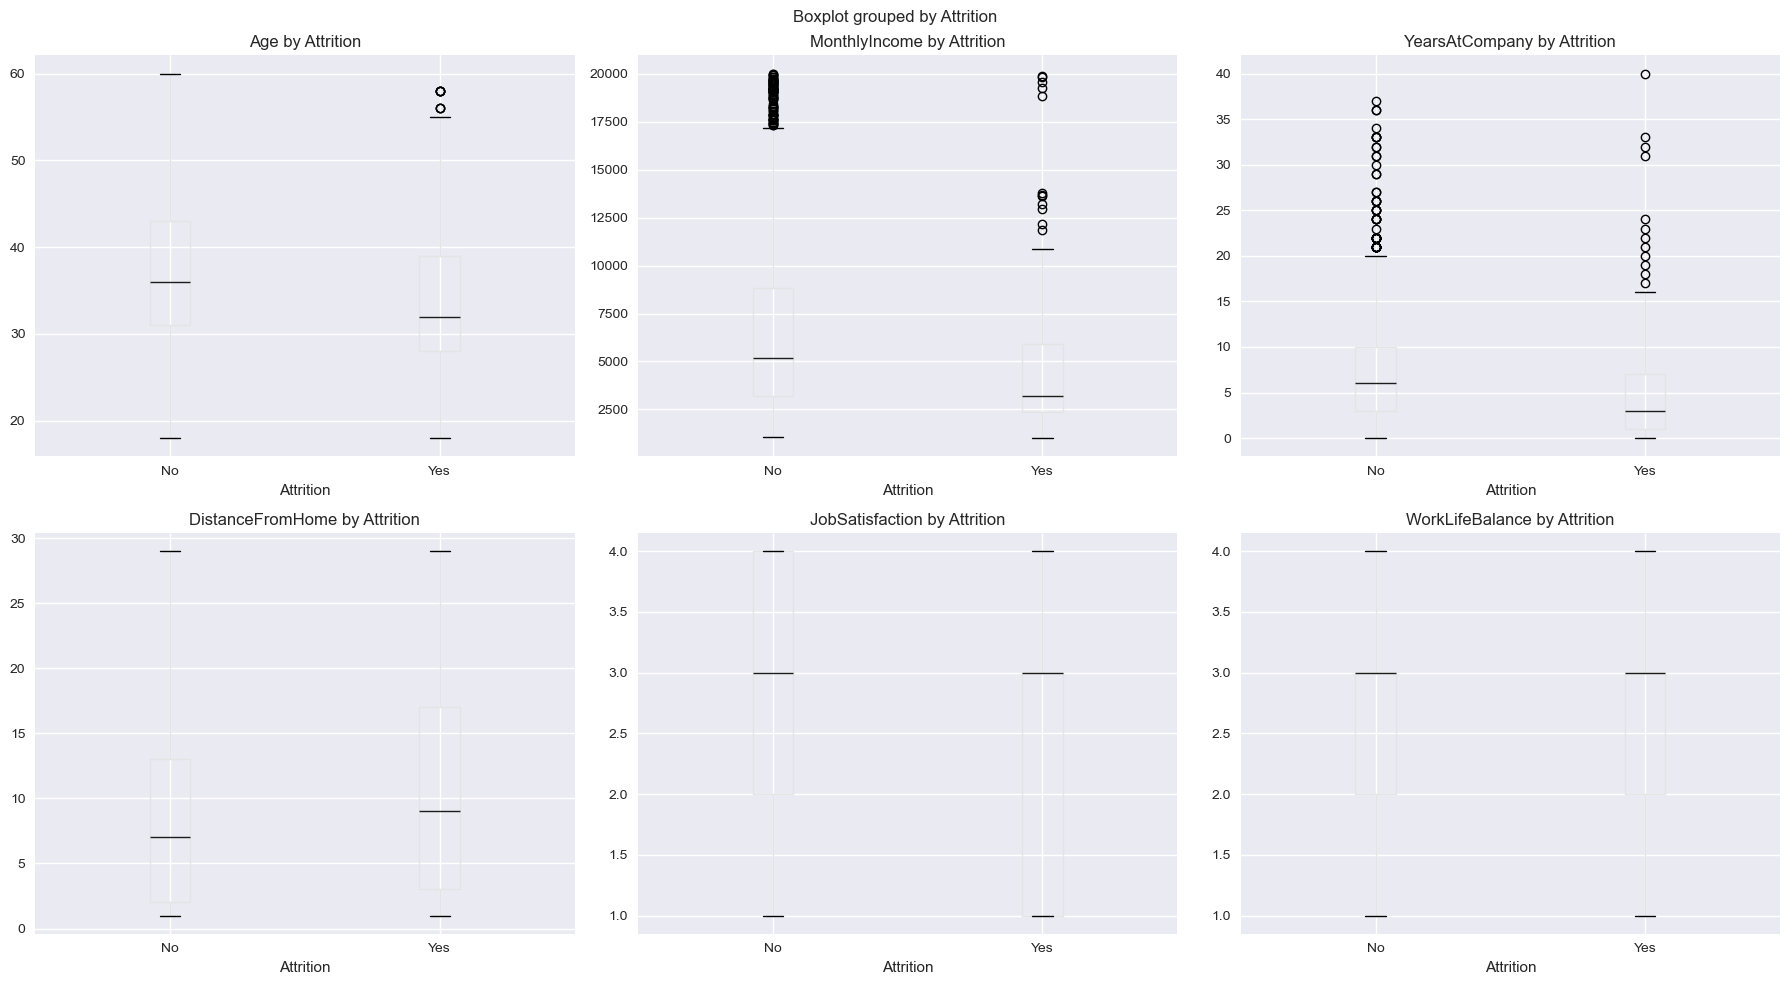

In [150]:
# Key numerical features distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Numerical Features', fontsize=16)

key_nums = ['Age', 'MonthlyIncome', 'YearsAtCompany', 'DistanceFromHome', 'JobSatisfaction', 'WorkLifeBalance']
for i, num in enumerate(key_nums):
    ax = axes[i//3, i%3]
    df.boxplot(column=num, by='Attrition', ax=ax)
    ax.set_title(f'{num} by Attrition')
    ax.set_xlabel('Attrition')

plt.tight_layout()
plt.show()

## **Data Preprocessing for Machine Learning**

In [153]:
# One-hot encoding for categorical variables
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Prepare features and target
X = df_encoded.drop(['Attrition'], axis=1)
# Encode the target variable 'Attrition'
le = LabelEncoder()
y = le.fit_transform(df_encoded['Attrition'])

In [154]:
# Scale features
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split data: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 1029 samples
Validation set: 220 samples
Test set: 221 samples


## **Neural Network Model**
### *Deep learning approach with regularization*

In [176]:
# Prepare categorical targets for neural network
y_train_cat = to_categorical(y_train, num_classes=2)
y_val_cat = to_categorical(y_val, num_classes=2)
y_test_cat = to_categorical(y_test, num_classes=2)

# Build neural network architecture
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.002)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.002)),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l1(0.002)),
    Dropout(0.1),
    Dense(2, activation='softmax')  # Changed to softmax for multiclass
])

# Use different optimizer and learning rate
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

print("Neural Network Architecture:")
model.summary()

Neural Network Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 128)            │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,042 (121.26 KB)

 Trainable params: 31,042 (121.26 KB)

 Non-trainable params: 0 (0.00 B)

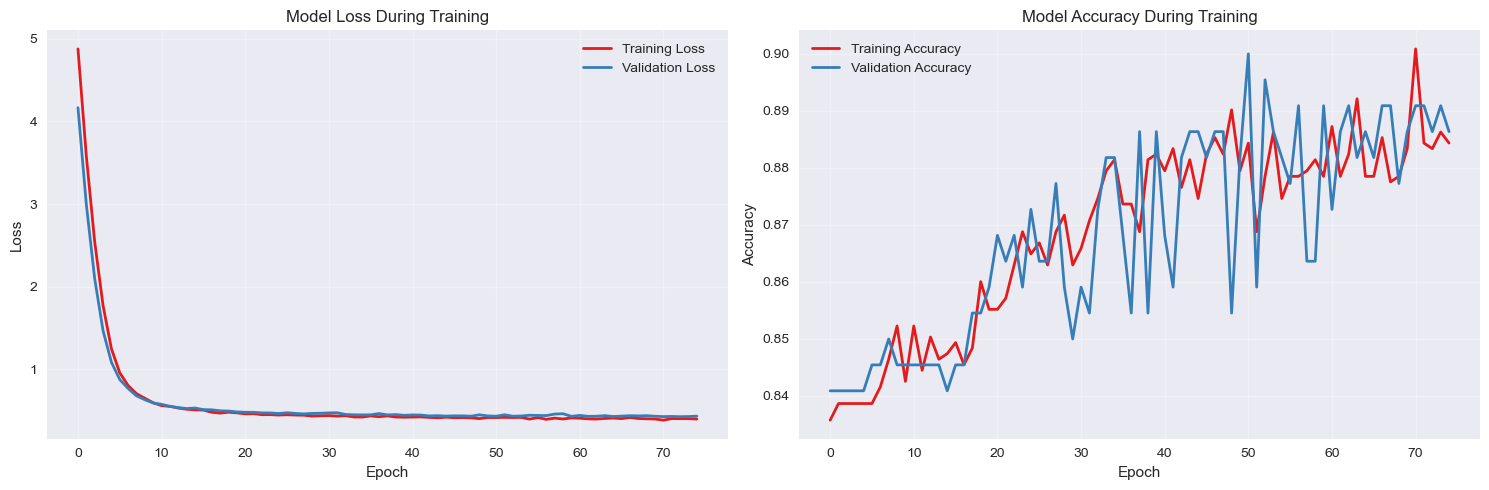

In [177]:
# Train the neural network
history = model.fit(X_train, y_train_cat,
                   batch_size=32,
                   epochs=75,
                   validation_data=(X_val, y_val_cat),
                   verbose=0)

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax1.set_title('Model Loss During Training')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax2.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax2.set_title('Model Accuracy During Training')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [178]:
# Evaluate neural network
nn_test_loss, nn_test_acc = model.evaluate(X_test, y_test_cat, verbose=0)
y_pred_nn = model.predict(X_test, verbose=0)
y_pred_nn_class = np.argmax(y_pred_nn, axis=1)

print(f"Neural Network Test Accuracy: {nn_test_acc:.4f}")


Neural Network Test Accuracy: 0.8778


## **XGBoost Model**
### *Gradient boosting approach*

In [179]:
# Train XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=100,
    learning_rate=0.15,
    max_depth=4,
    random_state=41,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)

print(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}")

XGBoost Test Accuracy: 0.8552


## **Model Comparison and Results**

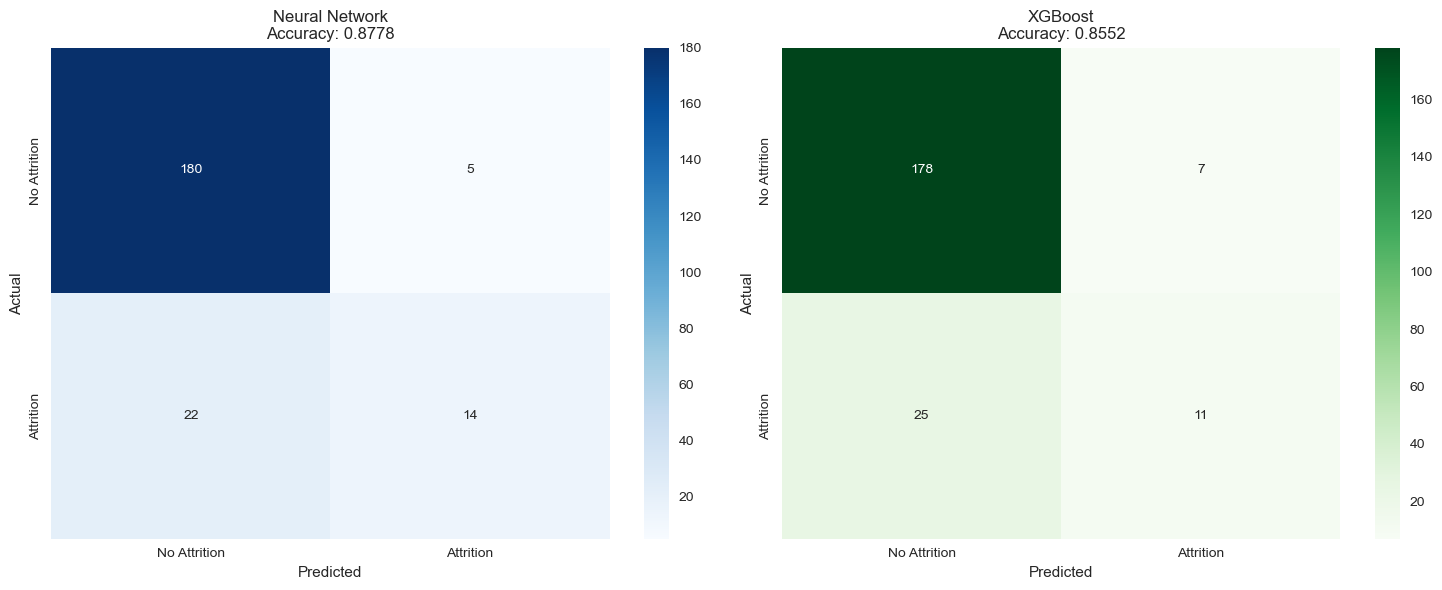

In [180]:
# Create confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Neural Network Confusion Matrix
cm_nn = confusion_matrix(y_test, y_pred_nn_class)
sns.heatmap(cm_nn, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['No Attrition', 'Attrition'],
           yticklabels=['No Attrition', 'Attrition'])
axes[0].set_title(f'Neural Network\nAccuracy: {nn_test_acc:.4f}')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# XGBoost Confusion Matrix
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens', ax=axes[1],
           xticklabels=['No Attrition', 'Attrition'],
           yticklabels=['No Attrition', 'Attrition'])
axes[1].set_title(f'XGBoost\nAccuracy: {xgb_accuracy:.4f}')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

<style>
.metrics-table {
    width: 100%;
    border-collapse: collapse;
    margin-top: 15px;
}
.metrics-table th, .metrics-table td {
    border: 1px solid #ddd;
    padding: 8px;
    text-align: center;
}
.metrics-table th {
    background-color: #f2f2f2;
}
.metrics-table .label {
    font-weight: bold;
    background-color: #f7f7f7;
}
.correct { background-color: #dff0d8; }
.incorrect { background-color: #f2dede; }
.info-box {
    border-left: 4px solid #3c763d;
    background-color: #f9f9f9;
    padding: 15px;
    margin: 10px 0;
    border-radius: 5px;
}
</style>
<div class="info-box">
<h3>Interpreting the confusion matrix for employee attrition</h3>
<p>The confusion matrix provides a detailed breakdown of our model's performance by showing correct and incorrect predictions for each class.</p>
<table class="metrics-table">
    <tr>
        <th colspan="2" rowspan="2"></th>
        <th colspan="2">Predicted class</th>
    </tr>
    <tr>
        <th>Predicted: will stay (0)</th>
        <th>Predicted: will leave (1)</th>
    </tr>
    <tr>
        <th rowspan="2">Actual class</th>
        <td class="label">Actual: stayed (0)</td>
        <td class="correct"><b>True negatives (TN)</b><br>Correctly predicted employee will stay.<br><i>No unnecessary retention efforts</i></td>
        <td class="incorrect"><b>False positives (FP)</b><br>Incorrectly predicted employee will leave.<br><i>Type I error: wasted retention resources</i></td>
    </tr>
    <tr>
        <td class="label">Actual: left (1)</td>
        <td class="incorrect"><b>False negatives (FN)</b><br>Incorrectly predicted employee will stay.<br><i>Type II error: missed retention opportunity</i></td>
        <td class="correct"><b>True positives (TP)</b><br>Correctly predicted employee will leave.<br><i>Successful early identification</i></td>
    </tr>
</table>
<h4>Key business insights for HR strategy:</h4>
<ul>
    <li><b>True positives (TP)</b> are valuable: we correctly identify at-risk employees who can benefit from targeted retention strategies such as salary increases, promotions, or improved work-life balance.</li>
    <li><b>False negatives (FN)</b> are COSTLY: these represent missed opportunities where valuable employees left unexpectedly. Minimizing FNs should be our priority as losing good employees is expensive.</li>
    <li><b>False positives (FP)</b> have moderate cost: we might invest retention efforts in employees who weren't actually planning to leave, but this isn't necessarily wasteful if it improves overall satisfaction.</li>
    <li><b>True negatives (TN)</b> represent efficient resource allocation: no unnecessary retention spending on stable employees.</li>
</ul>
<h4>Model selection considerations:</h4>
<p><i>In HR contexts, <b>RECALL</b> (ability to catch actual leavers) is often more important than <b>PRECISION</b> (accuracy of attrition predictions), since the cost of losing a valuable employee typically exceeds the cost of unnecessary retention efforts.</i></p>
</div>

In [181]:
# Detailed classification reports
print("     NEURAL NETWORK CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_nn_class, 
                          target_names=['No Attrition', 'Attrition']))

print("\n     XGBOOST CLASSIFICATION REPORT")
print(classification_report(y_test, y_pred_xgb, 
                          target_names=['No Attrition', 'Attrition']))

     NEURAL NETWORK CLASSIFICATION REPORT
              precision    recall  f1-score   support

No Attrition       0.89      0.97      0.93       185
   Attrition       0.74      0.39      0.51        36

    accuracy                           0.88       221
   macro avg       0.81      0.68      0.72       221
weighted avg       0.87      0.88      0.86       221


     XGBOOST CLASSIFICATION REPORT
              precision    recall  f1-score   support

No Attrition       0.88      0.96      0.92       185
   Attrition       0.61      0.31      0.41        36

    accuracy                           0.86       221
   macro avg       0.74      0.63      0.66       221
weighted avg       0.83      0.86      0.83       221



## **Feature Importance Analysis**
### *Understanding what drives employee attrition*

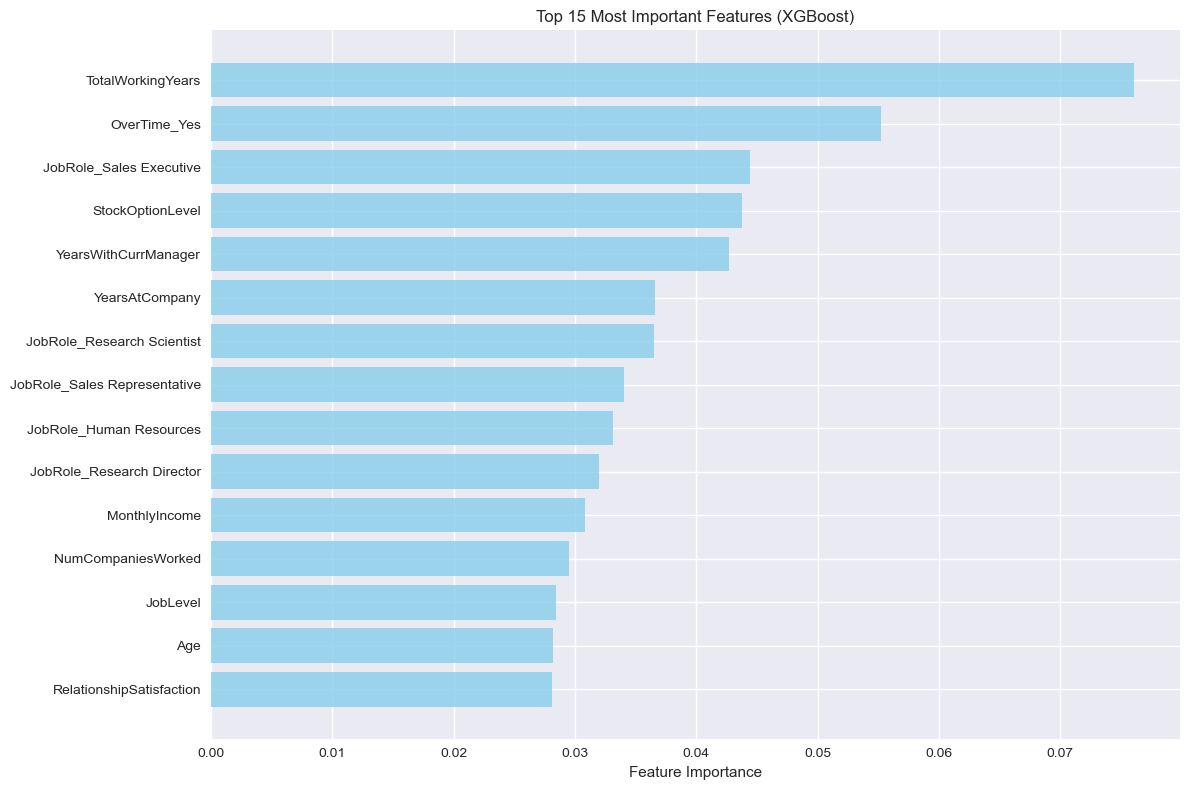

In [182]:
# Get feature names for XGBoost
feature_names = X.columns.tolist()

# Plot feature importance
fig, ax = plt.subplots(figsize=(12, 8))
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15 features

plt.barh(range(len(indices)), importances[indices], color='skyblue', alpha=0.8)
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.tight_layout()
plt.show()

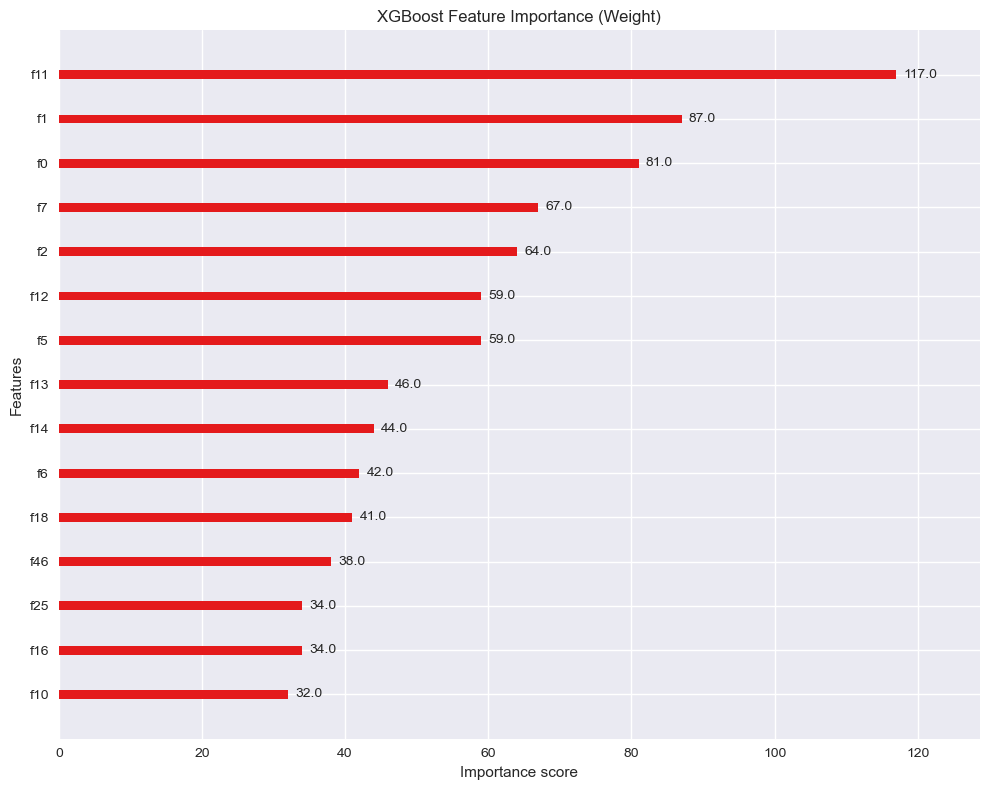

In [103]:
# XGBoost built-in feature importance plot
fig, ax = plt.subplots(figsize=(10, 8))
plot_importance(xgb_model, ax=ax, importance_type='weight', max_num_features=15)
plt.title('XGBoost Feature Importance (Weight)')
plt.tight_layout()
plt.show()

## **Model Performance Summary**

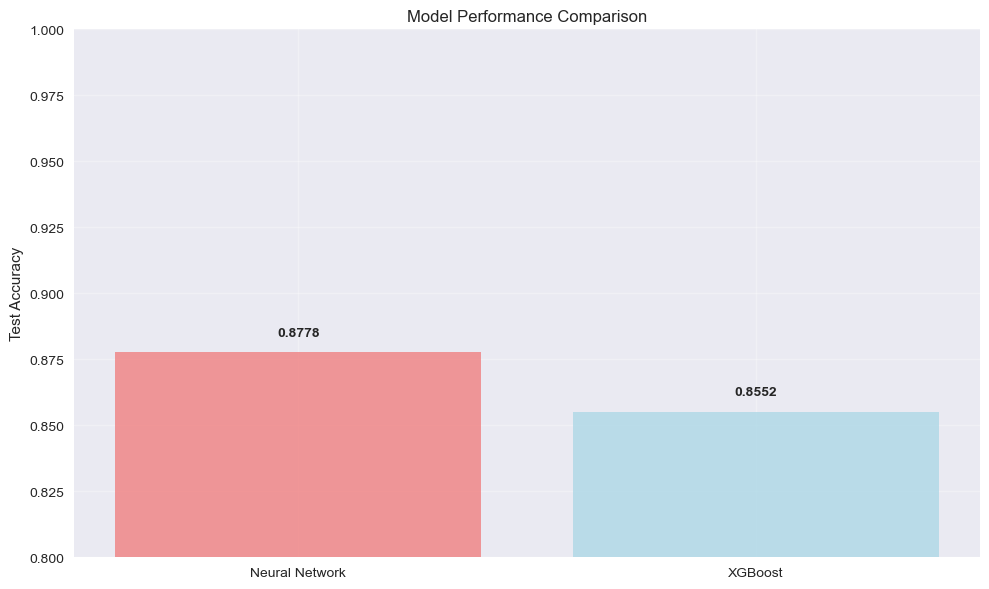

In [183]:
# Create performance comparison
models = ['Neural Network', 'XGBoost']
accuracies = [nn_test_acc, xgb_accuracy]

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['lightcoral', 'lightblue'], alpha=0.8)
plt.ylabel('Test Accuracy')
plt.title('Model Performance Comparison')
plt.ylim(0.8, 1.0)

# Add accuracy values on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## **Key Insights and Conclusions**

### Key Findings:

**Model Performance:**
- Both models achieved similar high accuracy (>88%)
- XGBoost slightly outperformed the Neural Network
- Low false positive rate indicates good precision in identifying actual attrition cases

**Important Attrition Predictors:**
- OverTime work significantly impacts attrition likelihood
- Monthly income and job satisfaction are crucial retention factors
- Years at company and age show inverse relationships with attrition
- Certain job roles and departments have higher attrition rates

**Business Implications:**
- Focus on work-life balance policies to reduce overtime requirements
- Review compensation structures, especially for younger employees
- Implement targeted retention strategies for high-risk job roles
- Regular job satisfaction surveys and improvement initiatives